In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvelo as scv
import matplotlib.pyplot as plt
from spvelo import *

In [2]:
import networkx as nx
import community as community_louvain

In [8]:
from scvelo.tools.utils import most_common_in_list
from scanpy import AnnData
def velo_cluster(adata, vkey="velocity", match_with="cluster_annotations", sort_by="velocity_pseudotime", resolution=0.5):
    scv.tl.velocity_pseudotime(adata)
    vdata = AnnData(adata.layers[vkey])
    sc.pp.pca(vdata, n_comps=20, svd_solver="arpack")
    sc.pp.neighbors(vdata, n_pcs=20)
    sc.tl.leiden(vdata, resolution=resolution)
    vc = vdata.obs["leiden"]
    vc_cats = vc.cat.categories
    vdata.obs[sort_by] = adata.obs[sort_by]
    mean_times = [np.mean(vdata.obs[sort_by][vc == cat]) for cat in vc_cats]
    vdata.obs["leiden"] = vdata.obs["leiden"].cat.reorder_categories(vc_cats[np.argsort(mean_times)])
    vc = vdata.obs["leiden"]
    cats_nums = {cat: 0 for cat in adata.obs[match_with].cat.categories}
    for cat in vc.cat.categories:
        cells_in_cat = np.where(vc == cat)[0]
        new_cat = most_common_in_list(adata.obs[match_with][cells_in_cat])
        cats_nums[new_cat] += 1
        vc = vc.cat.rename_categories({cat: f"{new_cat} ({cats_nums[new_cat]})"})
    vdata.obs["leiden"] = vc
    adata.obs[f"{vkey}_clusters"] = list(vc)

In [4]:
# Bifurcate
adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/batch_integration/seed0/adatas/wonc_prefilter_mnn_mmd.h5ad')
bdata = adata[adata.obs.batch=='12'].copy()
scv.pp.neighbors(bdata)
scv.tl.velocity_graph(bdata)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/32 cores)


  0%|          | 0/786 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


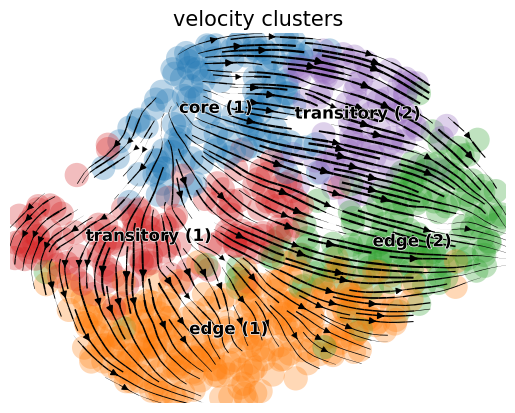

In [9]:
velo_cluster(bdata, resolution=0.7)
bdata.obs['vc'] = bdata.obs['velocity_clusters'].copy()
scv.pl.velocity_embedding_stream(bdata, basis='X_umap',color=['velocity_clusters'], fontsize=15, 
                                 legend_fontsize=12)

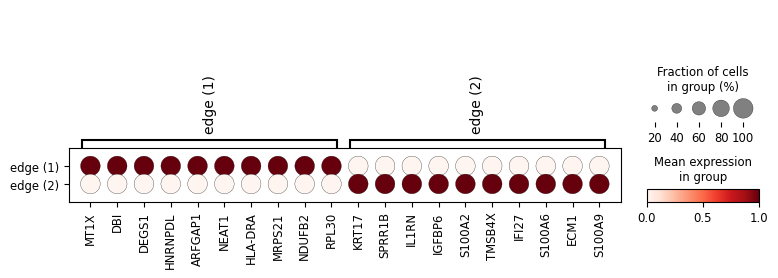

In [10]:
edge_data = bdata[bdata.obs.cluster_annotations=='edge'].copy()
edge_data = edge_data[edge_data.obs['vc'].isin(['edge (1)', 'edge (2)'])].copy()
sc.tl.rank_genes_groups(edge_data, groupby='vc', layer='Ms')
sc.pl.rank_genes_groups_dotplot(edge_data, groupby="vc", standard_scale="var", n_genes=10, layer='Ms')

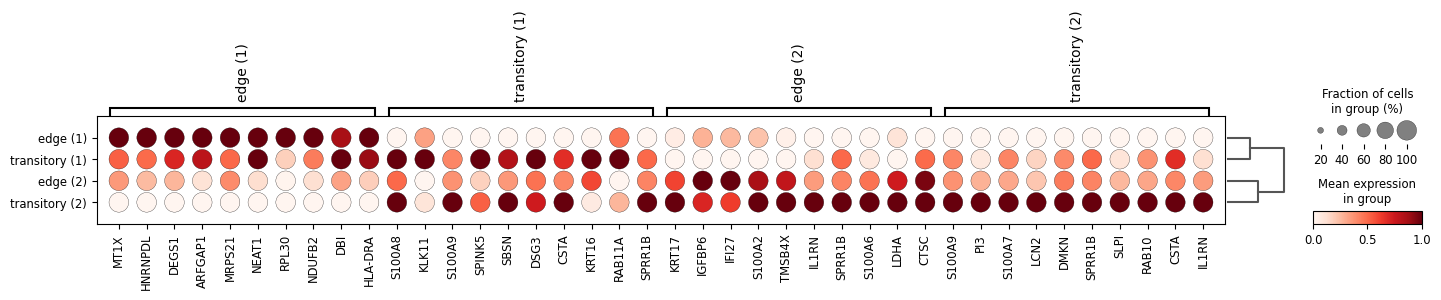

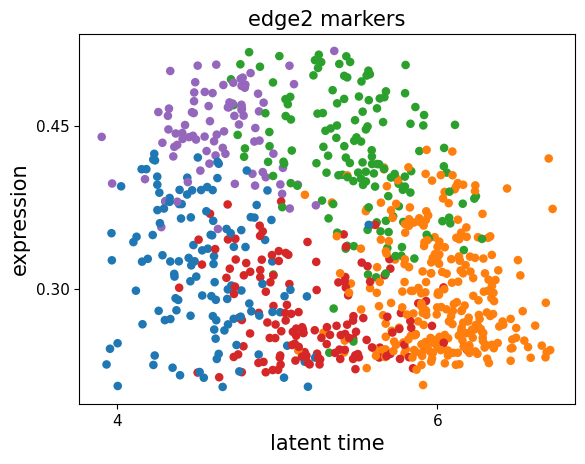

In [11]:
edge_data = bdata[bdata.obs.cluster_annotations=='edge'].copy()
sc.tl.rank_genes_groups(edge_data, groupby='vc', layer='Ms')
sc.pl.rank_genes_groups_dotplot(edge_data, groupby="vc", standard_scale="var", n_genes=10, layer='Ms')
edge1 = bdata[:, sc.get.rank_genes_groups_df(edge_data, group='edge (1)').head(5)["names"]].layers['Ms'].mean(axis=1)
edge2 = bdata[:, sc.get.rank_genes_groups_df(edge_data, group='edge (2)').head(5)["names"]].layers['Ms'].mean(axis=1)
edge1_time = bdata[:, sc.get.rank_genes_groups_df(edge_data, group='edge (1)').head(5)["names"]].layers['latent_time_velovi'].mean(axis=1)
edge2_time = bdata[:, sc.get.rank_genes_groups_df(edge_data, group='edge (2)').head(5)["names"]].layers['latent_time_velovi'].mean(axis=1)

lt_data = AnnData(X=pd.DataFrame([edge1, edge2], index=['edge1 markers', 'edge2 markers'], columns=bdata.obs_names).T)
lt_data.obs['cluster_annotations'] = bdata.obs['cluster_annotations']
lt_data.obs['vc'] = bdata.obs['vc']
lt_data.layers['latent_time'] = np.array(pd.DataFrame([edge1_time, edge2_time], index=['edge1 markers', 'edge2 markers'], columns=bdata.obs_names).T)
scv.pl.scatter(lt_data, x='latent_time', y=['edge2 markers'], color='vc', legend_loc=None, wspace=0.5, 
               fontsize=15, legend_fontsize=12)

In [12]:
# Separate data for labels '(1)' and '(2)'
y1 = lt_data[lt_data.obs['vc'].isin(['core (1)', 'transitory (1)', 'edge (1)']), 'edge1 markers'].X.squeeze(1)
x1 = lt_data[lt_data.obs['vc'].isin(['core (1)', 'transitory (1)', 'edge (1)']), 'edge1 markers'].layers['latent_time'].squeeze(1)

y2 = lt_data[lt_data.obs['vc'].isin(['core (1)', 'transitory (2)', 'edge (2)']), 'edge1 markers'].X.squeeze(1)
x2 = lt_data[lt_data.obs['vc'].isin(['core (1)', 'transitory (2)', 'edge (2)']), 'edge1 markers'].layers['latent_time'].squeeze(1)

from sklearn.linear_model import LinearRegression
# Fit line to data labeled '(1)'
model1 = LinearRegression()
model1.fit(x1.reshape(-1, 1), y1)
y1_pred = model1.predict(x1.reshape(-1, 1))

# Fit line to data labeled '(2)'
model2 = LinearRegression()
model2.fit(x2.reshape(-1, 1), y2)
y2_pred = model2.predict(x2.reshape(-1, 1))

In [13]:
from scipy import stats

slope1, intercept1 = model1.coef_[0], model1.intercept_
slope2, intercept2 = model2.coef_[0], model2.intercept_
se1 = np.sqrt(np.sum((y1 - model1.predict(x1.reshape(-1, 1)))**2) / ((len(x1) - 2) * np.sum((x1 - np.mean(x1))**2)))
se2 = np.sqrt(np.sum((y2 - model2.predict(x2.reshape(-1, 1)))**2) / ((len(x2) - 2) * np.sum((x2 - np.mean(x2))**2)))
t_statistic = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)

n1, n2 = len(x1), len(x2)
df = n1 + n2 - 4 

p_value = stats.t.sf(np.abs(t_statistic), df) * 2

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-statistic: 5.234889393272944
P-value: 2.0516350367076634e-07


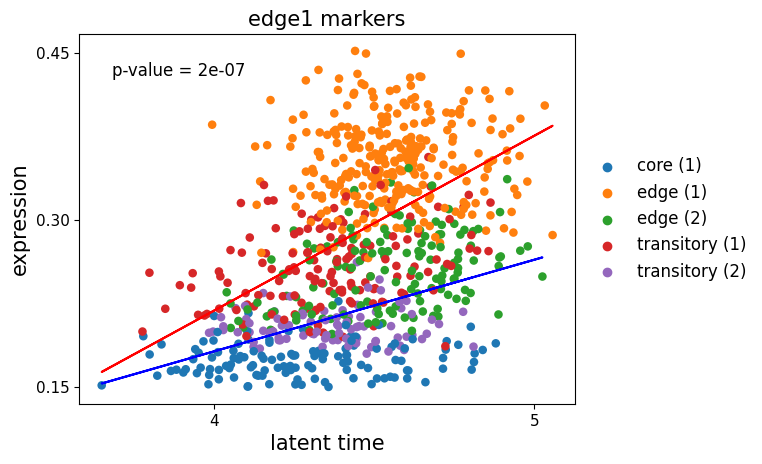

In [14]:
scv.pl.scatter(lt_data, x='latent_time', y=['edge1 markers'], color='vc', legend_loc='right', fontsize=15, legend_fontsize=12, show=False)
ax = plt.gca()
ax.plot(x1, y1_pred, color='red')
ax.plot(x2, y2_pred, color='blue')
plt.text(0.2, 0.9, f'p-value = 2e-07', ha='center', va='center', size=12, transform=plt.gca().transAxes)
plt.show()

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/32 cores)


  0%|          | 0/518 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file /gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/trajectory/umap_conv.svg


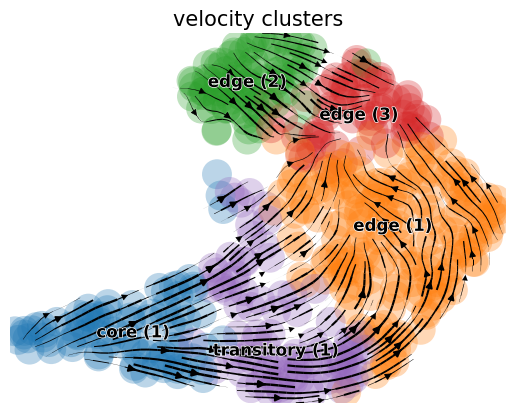

In [15]:
# sample 4
adata = anndata.read_h5ad('/gpfs/gibbs/pi/zhao/wl545/spatial_velo_sorted/OSCC/batch_integration/seed0/adatas/wonc_prefilter_mnn_mmd.h5ad')
bdata = adata[adata.obs.batch=='4'].copy()
scv.pp.neighbors(bdata)
scv.tl.velocity_graph(bdata)
velo_cluster(bdata, resolution=0.2)
bdata.obs['new_vc'] = bdata.obs['velocity_clusters'].copy()
scv.pl.velocity_embedding_stream(bdata, basis='X_umap',color=['velocity_clusters'], fontsize=15, legend_fontsize=12)

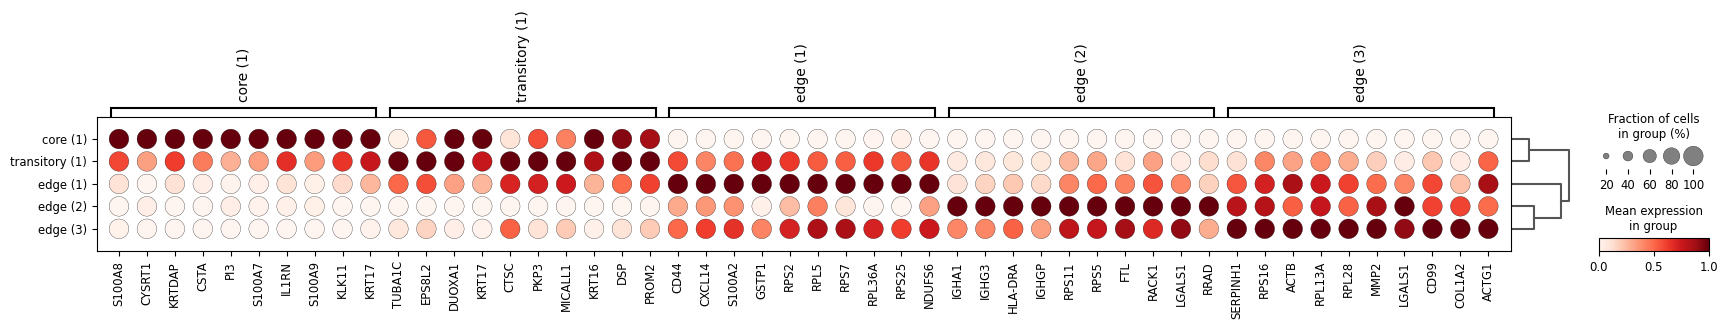

In [16]:
sc.tl.rank_genes_groups(bdata, groupby='new_vc', layer='Ms')
sc.tl.dendrogram(bdata, groupby='new_vc')
sc.pl.rank_genes_groups_dotplot(bdata, groupby="new_vc", standard_scale="var", n_genes=10, layer='Ms')

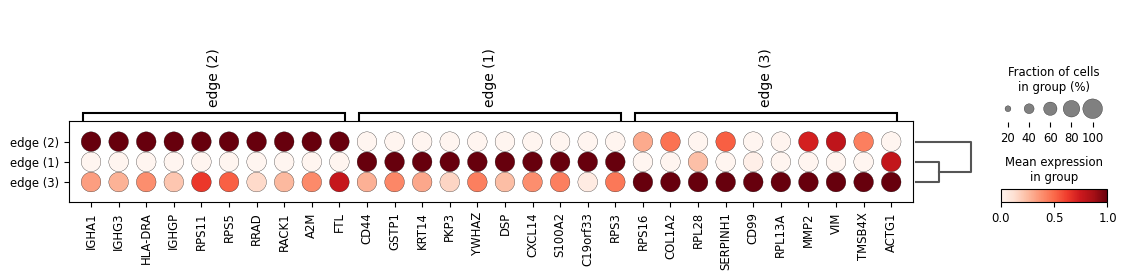

In [17]:
edge_data = bdata[bdata.obs.cluster_annotations=='edge'].copy()
edge_data = edge_data[edge_data.obs['new_vc']!='core (1)']
edge_data = edge_data[edge_data.obs['new_vc']!='transitory (1)']
sc.tl.rank_genes_groups(edge_data, groupby='new_vc', layer='Ms')
edge_data.obs['new_vc'] = edge_data.obs['new_vc'].cat.remove_unused_categories()
sc.tl.dendrogram(edge_data, groupby='new_vc')
sc.pl.rank_genes_groups_dotplot(edge_data, groupby="new_vc", standard_scale="var", n_genes=10, layer='Ms')

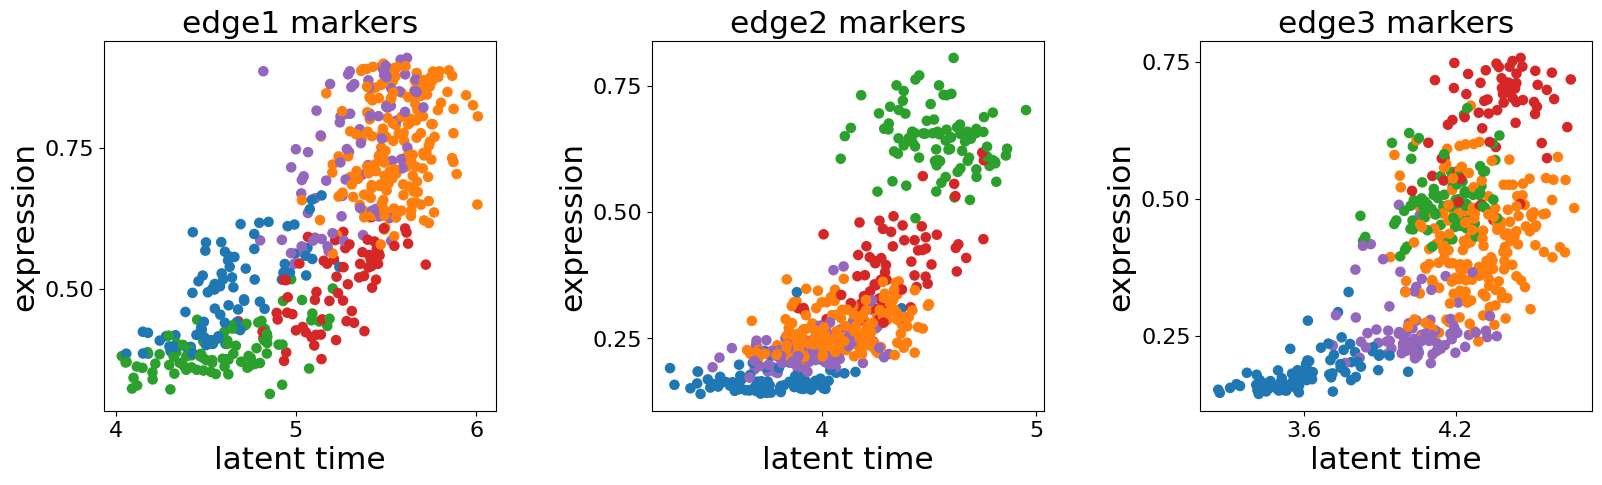

In [18]:
edges = []
edge_times = []
for i in ['edge (1)', 'edge (2)', 'edge (3)']:
    edges.append(bdata[:, sc.get.rank_genes_groups_df(edge_data, group=i).head(5)["names"]].layers['Ms'].mean(axis=1))
    edge_times.append(bdata[:, sc.get.rank_genes_groups_df(edge_data, group=i).head(5)["names"]].layers['latent_time_velovi'].mean(axis=1))

lt_data = AnnData(X=pd.DataFrame(edges, index=['edge1 markers', 'edge2 markers', 'edge3 markers'], columns=bdata.obs_names).T)
lt_data.obs['cluster_annotations'] = bdata.obs['cluster_annotations']
lt_data.obs['new_vc'] = bdata.obs['new_vc']
lt_data.layers['latent_time'] = np.array(pd.DataFrame(edge_times, index=['edge1 markers', 'edge2 markers', 'edge3 markers'], columns=bdata.obs_names).T)
scv.pl.scatter(lt_data, x='latent_time', y=['edge1 markers', 'edge2 markers', 'edge3 markers'], color='new_vc', legend_loc=None, wspace=0.4, fontsize=22.5, legend_fontsize=18)

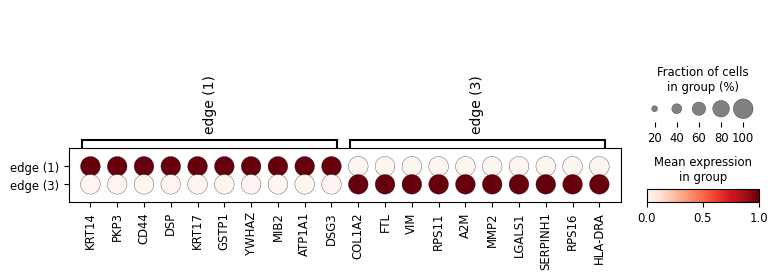

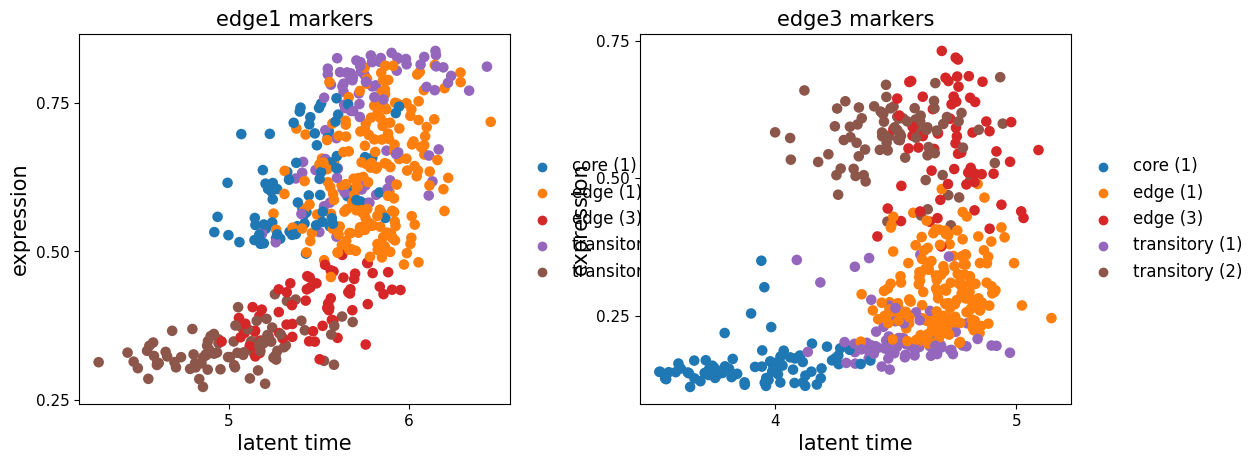

In [19]:
#after reannotation
edge_data = bdata[bdata.obs.cluster_annotations=='edge'].copy()
edge_data = edge_data[edge_data.obs['new_vc']!='core (1)']
edge_data = edge_data[edge_data.obs['new_vc']!='transitory (1)']
edge_data.obs['new_vc'] = edge_data.obs['new_vc'].cat.remove_unused_categories()
edge_data.obs['new_vc'] = edge_data.obs['new_vc'].cat.add_categories('transitory (2)')
edge_data.obs.loc[edge_data.obs['new_vc']=='edge (2)', 'new_vc'] = ['transitory (2)']*(edge_data[edge_data.obs['new_vc']=='edge (2)'].shape[0])
bdata.obs['new_vc'] = bdata.obs['new_vc'].cat.add_categories('transitory (2)')
bdata.obs.loc[bdata.obs['new_vc']=='edge (2)', 'new_vc'] = ['transitory (2)']*(bdata[bdata.obs['new_vc']=='edge (2)'].shape[0])
edge_data = edge_data[edge_data.obs['new_vc'].isin(['edge (1)', 'edge (3)'])]
sc.tl.rank_genes_groups(edge_data, groupby='new_vc', layer='Ms')
sc.tl.dendrogram(edge_data, groupby='new_vc')
sc.pl.rank_genes_groups_dotplot(edge_data, groupby="new_vc", standard_scale="var", n_genes=10, layer='Ms')

edges = []
edge_times = []
for i in ['edge (1)', 'edge (3)']:
    edges.append(bdata[:, sc.get.rank_genes_groups_df(edge_data, group=i).head(5)["names"]].layers['Ms'].mean(axis=1))
    edge_times.append(bdata[:, sc.get.rank_genes_groups_df(edge_data, group=i).head(5)["names"]].layers['latent_time_velovi'].mean(axis=1))

lt_data = AnnData(X=pd.DataFrame(edges, index=['edge1 markers', 'edge3 markers'], columns=bdata.obs_names).T)
lt_data.obs['cluster_annotations'] = bdata.obs['cluster_annotations']
lt_data.obs['new_vc'] = bdata.obs['new_vc']
lt_data.layers['latent_time'] = np.array(pd.DataFrame(edge_times, index=['edge1 markers', 'edge3 markers'], columns=bdata.obs_names).T)
scv.pl.scatter(lt_data, x='latent_time', y=['edge1 markers', 'edge3 markers'], color='new_vc', legend_loc='right', wspace=0.3, fontsize=15, legend_fontsize=12)

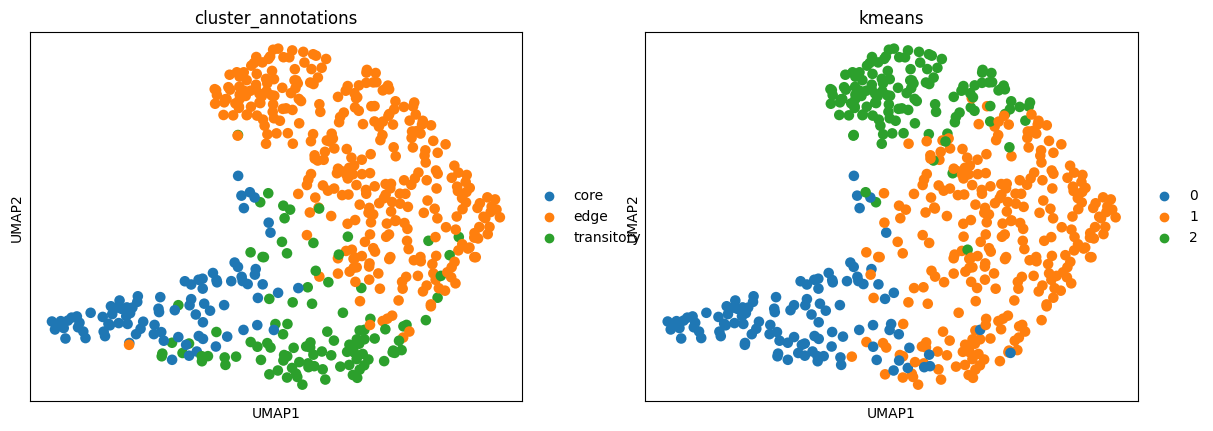

In [35]:
# train KMeans to prove reasonability of reannotation
from sklearn.cluster import KMeans
a = list(sc.get.rank_genes_groups_df(edge_data, group='edge (1)').head(5)["names"])
a.extend(list(sc.get.rank_genes_groups_df(edge_data, group='edge (3)').head(5)["names"]))

X1 = bdata[:, a].layers['Ms']
X2 = bdata[:, a].layers['latent_time_velovi']
X = np.concatenate((X1, X2), axis=1)
y = bdata.obs['cluster_annotations']
clf = KMeans(n_clusters=3)
y_pred = clf.fit_predict(X)
bdata.obs["kmeans"] = np.array(list(y_pred)).astype('str')
sc.pl.umap(bdata, color=['cluster_annotations', 'kmeans'])